# Modelling - Topic Modeling
## Portal da Queixa
### Changes may be required due to Portal da Queixa's continous updates

Lefties Group

### Load packages and do the initializations

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import category_encoders as ce
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 

import gensim         
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/Users/lagonick/opt/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Importing the data from the provious webscraping

Delete the Unnamed: 0 column and make the complainID the index column of the DataFrame

In [2]:
df = pd.read_excel("complains_data.xlsx", index_col="complainID")

/Users/lagonick/opt/anaconda3/lib/python3.7/site-packages/openpyxl/compat/numbers.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.float,


In [3]:
cols_to_drop = ["Unnamed: 0"]
df = df.drop(cols_to_drop, axis=1)

In [4]:
df.head()

,complainStatus,complainUser,complainTitle,complainViews,complainText,complainDate
complainID,,,,,,
59476521,Aguarda resposta,Susana,Lefties - Devolução de artigos,55,Recebi a minha encomenda no dia 19-04-2021 e i...,5 de maio 2021
58935721,Aguarda resposta,Cassia Barcelos,Lefties - Troca de peças compradas on-line,175,"Boa noite, _x000D_\nVenho mostrar o meu total ...",23 de abril 2021
58754421,Aguarda resposta,Milene,Lefties - Encomenda não entregue,62,A minha encomenda que fiz no dia 19 de Março n...,20 de abril 2021
58696921,Aguarda resposta,Mariana Ferreira,Lefties - Encomenda não entregue nem resolvem ...,41,Encomenda nr ‪90003989775‬ já deveria ter sido...,19 de abril 2021
58650521,Resolvida,Olga Santos,Lefties - Encomenda não entregue,124,Bom dia. Fiz uma encomenda online na Lefties n...,17 de abril 2021


## Working with Text

Cleaning and normalization of the raw text.

In [5]:
def textPreProcess(rawText, lowerText=True, charsToRemove=r'\_x000d_|\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-|\/', removeNumbers=True, removeLineBreaks=True, removeStopWords=True):
    cleanedText = []
    for x in rawText[:]:
        procText = x
        if lowerText:
            procText = procText.lower()
        if len(charsToRemove)>0:
            procText = re.sub(charsToRemove,' ',procText)
        if removeNumbers:
            procText = re.sub(r'\d+',' ',procText)
        if removeLineBreaks:
            procText = procText.replace('\n',' ').replace('\r', '')
        if removeStopWords:
            stop_words = set(stopwords.words('portuguese'))
            tokenizedText = word_tokenize(procText, language='portuguese')
            cText = []
            for t in tokenizedText:
                if t not in stop_words:
                    cText.append(t)
            procText = ""
            for w in cText:
                procText = procText + w + ' '
            procText = procText.rstrip() # rstring (remove spaces at the right of the string)

        if procText != "":
            cleanedText.append(procText)
    return cleanedText

### Adding a column using the function to the original data frame with the text processing

In [6]:
df["processText"] = pd.DataFrame(data=textPreProcess(df.complainText), index=df.index)

In [7]:
df

,complainStatus,complainUser,complainTitle,complainViews,complainText,complainDate,processText
complainID,,,,,,,
59476521,Aguarda resposta,Susana,Lefties - Devolução de artigos,55,Recebi a minha encomenda no dia 19-04-2021 e i...,5 de maio 2021,recebi encomenda dia imediatamente dia seguir ...
58935721,Aguarda resposta,Cassia Barcelos,Lefties - Troca de peças compradas on-line,175,"Boa noite, _x000D_\nVenho mostrar o meu total ...",23 de abril 2021,boa noite venho mostrar total descontentamento...
58754421,Aguarda resposta,Milene,Lefties - Encomenda não entregue,62,A minha encomenda que fiz no dia 19 de Março n...,20 de abril 2021,encomenda fiz dia março entregue devido ctt ex...
58696921,Aguarda resposta,Mariana Ferreira,Lefties - Encomenda não entregue nem resolvem ...,41,Encomenda nr ‪90003989775‬ já deveria ter sido...,19 de abril 2021,encomenda nr ‪ ‬ deveria ter sido entregue sem...
58650521,Resolvida,Olga Santos,Lefties - Encomenda não entregue,124,Bom dia. Fiz uma encomenda online na Lefties n...,17 de abril 2021,bom dia fiz encomenda online lefties dia abril...
...,...,...,...,...,...,...,...
8776417,Sem resolução,Maria Fernandes,Lefties - Hematoma grave na face,1305,Os sapatos prateados estavam na prateleira aci...,13 de março 2017,sapatos prateados prateleira acima altura pres...
7865917,Sem resolução,patricia vidal,Lefties - Mau atendimento,1829,Bom dia.Ja por diversas vezes me dirigi a voss...,23 de janeiro 2017,bom dia ja diversas vezes dirigi vossa loja aq...
5810316,Sem resolução,Julia Almeida,Lefties - Troca,3777,Boa tarde fui a lefties C.C. Arrábida fiz uma ...,19 de setembro 2016,boa tarde lefties c c arrábida fiz compra valo...


## Other Processing Functions

In [8]:
# Tokenize texts
def tokenize_words(texts):
    words_new = []
    for w in (texts[:]):
        w_token = word_tokenize(w)
        if w_token != '':
            words_new.append(w_token)
    return words_new

In [9]:
# Stemm texts
def stemming(words):
    procText = []
    for w in (words[:]):
        stemmed_word = [snowball.stem(x) for x in (w[:])]
        procText.append(stemmed_word)
    return procText

In [10]:
# Function to count the frequency of n-grams (Adapted from https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34)
# Uses CountVectorizer from sklearn instead of FreqDist from NLTK
def get_top_n_words(corpus, n=None, nGrams=1): 
    vec = CountVectorizer(max_df=0.8, stop_words=stop_words,ngram_range=(nGrams,nGrams), max_features=10000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [11]:
# Function to lemmatize words
def lemmatize(words):
  lemmatizer = WordNetLemmatizer()
  procText = []
  for w in (words[:]):
    lemmatized_word = [lemmatizer.lemmatize(x) for x in (w[:])]
    procText.append(lemmatized_word)
  return procText

# Analysis

In [12]:
df["tokenizedText"] = tokenize_words(df["processText"])

In [13]:
df["tokenizedText"]

complainID
59476521    [recebi, encomenda, dia, imediatamente, dia, s...
58935721    [boa, noite, venho, mostrar, total, descontent...
58754421    [encomenda, fiz, dia, março, entregue, devido,...
58696921    [encomenda, nr, ‪, ‬, deveria, ter, sido, entr...
58650521    [bom, dia, fiz, encomenda, online, lefties, di...
                                  ...                        
8776417     [sapatos, prateados, prateleira, acima, altura...
7865917     [bom, dia, ja, diversas, vezes, dirigi, vossa,...
5810316     [boa, tarde, lefties, c, c, arrábida, fiz, com...
5716216     [comprei, umas, sapatilhas, promoção, disseram...
3071916     [altura, natal, filhas, receberam, prendas, br...
Name: tokenizedText, Length: 177, dtype: object

In [14]:
df = df[df["tokenizedText"].str.len()>0]

df["tokenizedText"] = lemmatize(df["tokenizedText"])

In [15]:
# Create dictionary (needed for LDA)
id2word = corpora.Dictionary(df["tokenizedText"])

In [16]:
# Create corpus
corpus = df["tokenizedText"]

In [17]:
# Create TDM (Frequency)
tdm = [id2word.doc2bow(text) for text in corpus]

In [24]:
# Build LDA model (can take from 2 to 10 minutes depending on the computer)
lda_model = gensim.models.ldamodel.LdaModel(corpus=tdm,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [25]:
# Print the keywords in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[tdm]
# Interpretation: Topic 0 is represented as 0.055"walking" + 0.054"garden" + ...

[(0, '0.027*"dia" + 0.025*"encomenda" + 0.011*"dinheiro" + 0.010*"cliente" + 0.008*"lefty" + 0.008*"loja" + 0.008*"apoio" + 0.007*"artigos" + 0.007*"mail" + 0.007*"nada"'), (1, '0.023*"loja" + 0.011*"troca" + 0.010*"dia" + 0.007*"ter" + 0.007*"lefty" + 0.006*"fazer" + 0.006*"poi" + 0.006*"funcionária" + 0.006*"cliente" + 0.005*"talão"'), (2, '0.037*"encomenda" + 0.034*"dia" + 0.012*"fiz" + 0.010*"recebi" + 0.010*"lefty" + 0.009*"entrega" + 0.009*"online" + 0.008*"cliente" + 0.008*"email" + 0.007*"compra"')]


In [26]:
# Visualize the topics (can take some mintues to run)
#vis = pyLDAvis.gensim.prepare(lda_model, tdm, id2word)
#pyLDAvis.show(vis)

# If it is a newwer version of puLDavis, use this instead of the previous
vis = gensimvis.prepare(lda_model, tdm, id2word)
pyLDAvis.display(vis)

#pyLDAvis.enable_notebook() # Remove remarks to see in notebook instead of the browser

### Evaluation of topic models
Good description at: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [27]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(tdm))  # lower value is better (some liteture do not recommend the use of this measure)


Perplexity:  -7.177821552881229


In [28]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3760401023631487


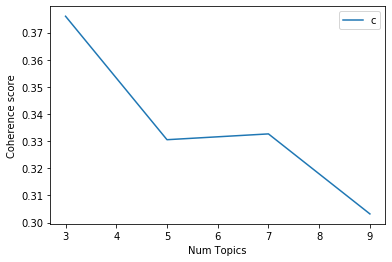

In [23]:
# HOW TO SELECT K (based on https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# ATTENTION!!!! Can take a LONG time to run.
lowerBound = 3
upperBound = 11
step = 2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=tdm, texts=corpus, start=lowerBound, limit=upperBound, step= step)

# Show graph
x = range(lowerBound, upperBound, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# The coherence score is decreasing. A higher value should be chosen, because as K increases the probability of having repeated keywords increases.
# ...So, in this case we may choose 8, as there is an inflaction at K=8